## Энергетический оракул
Ноутбук команды #12

Работа выполнена на основе модели LightGBM


### 1. Подготовка данных

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import re

from tqdm import tqdm

from data_preprocess import DataTransformer
random_state = 12345
NUM_ITERATIONS = 5000

In [8]:
# Функция для вычисления метрики mae по дням из почасовых массивов данных

def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)
# Функция для вычисления метрик по дням из почасовых массивов данных

def metrics_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    mae = mean_absolute_error(y_true_grouped, y_pred_grouped)
    mape = mean_absolute_percentage_error(y_true_grouped, y_pred_grouped)
    r2 = r2_score(y_true_grouped, y_pred_grouped)
    return mae, mape, r2

#### 1.5 Чтение файлов с данными
Данные объединяются в один датасет

In [9]:
path = 'data'
transformer = DataTransformer() #инициализируем трансформер

In [10]:
all_ds, test_begin, test_end = transformer.open_file() #оставляем поле пустым что бы использовать открытый датасет

начало открытого теста: 2023-04-01 00:00:00     конец открытого теста: 2023-08-01 00:00:00


In [11]:
print(all_ds.shape)

(40152, 7)


In [12]:
all_ds = transformer.transform(all_ds)

date:  0
fill_weather_columns:  0
Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'holidays', 'preholidays'],
      dtype='object')
holydays:  0
create_lags:  0
VVP:  0
true weather:  0


In [13]:
print(all_ds.shape)

(40152, 30)


In [14]:
duplicates = all_ds.duplicated()

duplicates.sum()

0

#### 1.10 Демонстрация сформированного датасета

In [15]:
# Итоговый набор колонок
all_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability', 'holidays', 'preholidays', 'temp_last_day',
       'target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_168',
       'target_lag_336', 'VVP', 'P', 'U', 'WW', 'Td', 'N', 'S', 'W', 'E'],
      dtype='object')

In [16]:
all_ds.head()

,date,time,target,temp,temp_pred,weather_pred,weather_fact,cloudy,rainy,windy,...,target_lag_336,VVP,P,U,WW,Td,N,S,W,E
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,763.5,100.0,1.0,2.0,1.0,0.0,0.0,0.0
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,764.3,93.0,1.0,1.0,1.0,0.0,0.0,0.0
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер,2,0,1,...,0.0,1.8,765.0,93.0,0.0,2.0,1.0,0.0,0.0,0.0
3,2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм",2,0,1,...,0.0,1.8,765.8,87.0,0.0,1.0,1.0,0.0,0.0,0.0
4,2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм",2,0,1,...,0.0,1.8,766.6,87.0,0.0,1.0,1.0,0.0,0.0,0.0


In [17]:
all_ds[duplicates].sort_values(['date','time']).tail(56)

,date,time,target,temp,temp_pred,weather_pred,weather_fact,cloudy,rainy,windy,...,target_lag_336,VVP,P,U,WW,Td,N,S,W,E


#### 1.11 Исключение лишних колонок

In [18]:
# Отбираем признаки. Все лишние колонки здесь отбрасываем, кроме 'date', которую уберем позже 

feature_cols = list(all_ds.columns)

# выбрасываем взгляд в прошлое и расшифрованную погоду
drop_list = ['target', 'weather_pred', 'weather_fact', 'temp']

# выбрасываем признаки, найденные процедурно в процессе оптимизации
# КОМАНДЕ: здесь можно добавлять признаки на выброс с целью оптимизации
drop_list = drop_list + ['target_lag_48', 'target_lag_168', 'target_lag_336',
                        'target_lag_24', 'windy', 'clear',
                        'target_lag_72','has_rain_probability', #'temp_last_day',
                        'N', 'S', 'W', 'E', 'P','U', 'WW', 'Td', 'preholidays',  'cloudy',
 'rainy',
 'rain_probability','temp_pred', 'holidays', 'VVP'] 

for name in drop_list:
    feature_cols.remove(name)

# Итоговый список признаков
feature_cols

['date', 'time', 'temp_last_day']

#### 1.12 Выделение наборов данных для обучения, валидации и тестирования

Выделялось два набора данных для обучения и валидации:
1. Обучение на данных с 2019 по 2021 с валидацией на 2022
2. Обучение на данных с 2019 по 2022 с валидацией на первом квартале 2023

Первый набор позволяет оценить влияние сезонности на обучение и предсказания, второй позволяет обучить модель на большем объеме данных и на более актуальных данных.

In [19]:
# Формируем набор датасетов для обучения и проверки

features = all_ds[feature_cols]
target = all_ds['target']

# Функция для выделения временных интервалов из таблиц признаков и целей
# на этом этапе отбрасываем колонку 'date'
def features_interval(features, target, date1, date2):
    
    features_interval = features[ (features['date']>=date1) & (features['date']<date2) ]
    target_interval = target[features_interval.index]
    

    features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])

    # Преобразование столбца 'time' в timedelta
    features_interval.loc[:, 'time'] = pd.to_timedelta(features_interval['time'], unit='h')

    # Создание нового столбца 'datetime', объединяющего 'date' и 'time'
    features_interval.loc[:, 'datetime'] = features_interval['date'] + features_interval['time']

    # Установка столбца 'datetime' в качестве индекса
    features_interval.set_index('datetime', inplace=True)

    features_interval = features_interval.drop('date', axis=1)
    features_interval = features_interval.drop('time', axis=1)
    target_interval.index = features_interval.index

    return features_interval, target_interval


# для проверки на тестовой выборке будем учиться на всем тренировочном датасете
features_all_train, target_all_train = features_interval(features, target, '2019-01-01', test_begin)
features_open_test, target_open_test = features_interval(features, target, test_begin, test_end )


/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_69652/3202848139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_69652/3202848139.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_interval.loc[:, 'date'] = pd.to_datetime(features_interval['date'])
/var/folders/4y/zccbjjq17fgd73999h5g3ltr0000gn/T/ipykernel_69652/3202848139.py:17: SettingWithCopyWarning: 
A value i

In [20]:
features_all_train.head(5)

,temp_last_day
datetime,
2019-01-01 00:00:00,2.0
2019-01-01 01:00:00,2.0
2019-01-01 02:00:00,2.0
2019-01-01 03:00:00,2.0
2019-01-01 04:00:00,2.0


In [21]:
duplicates_f = features_all_train.index.duplicated()

duplicates_f.sum()

0

In [22]:
print(duplicates_f.shape)

(37224,)


In [23]:
features_all_train[duplicates_f].sort_values('datetime').head(56)

,temp_last_day
datetime,


In [24]:
features_open_test.head(5)

,temp_last_day
datetime,
2023-04-01 00:00:00,7.2
2023-04-01 01:00:00,7.2
2023-04-01 02:00:00,7.2
2023-04-01 03:00:00,7.9
2023-04-01 04:00:00,7.9


## AUTO TS

In [25]:
from autots import AutoTS, load_daily, load_hourly, load_live_daily, create_regressor
from autots.models.model_list import model_lists
import tensorflow as tf


In [26]:
from pytorch_lightning.core.module import LightningModule


In [27]:
import holidays

In [28]:
russian = holidays.RU()

from sklearn.metrics import pairwise
#import neuralprophet
import scipy
from arch import arch_model
import pytorch_forecasting 
from neuralprophet import NeuralProphet
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import gluonts.model
from prophet import Prophet
import statsmodels.api as sm

In [29]:
print(model_lists.keys())

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])


In [30]:
df_train_autots = pd.concat([target_all_train, features_all_train ], axis=1)

In [31]:
df_train_autots.head()

,target,temp_last_day
datetime,,
2019-01-01 00:00:00,481.510,2.0
2019-01-01 01:00:00,462.872,2.0
2019-01-01 02:00:00,449.718,2.0
2019-01-01 03:00:00,430.908,2.0
2019-01-01 04:00:00,415.163,2.0


In [32]:
duplicates = df_train_autots.index.duplicated()

duplicates.sum()

0

In [33]:
df_test_autots = pd.concat([target_open_test, features_open_test ], axis=1)
df_test_autots.head(3)

,target,temp_last_day
datetime,,
2023-04-01 00:00:00,479.282,7.2
2023-04-01 01:00:00,445.182,7.2
2023-04-01 02:00:00,424.225,7.2


In [34]:
#Config
forecast_length=24
frequency='infer'
drop_most_recent=0

In [35]:
regr_train, regr_fcst = create_regressor(
    df_train_autots,
    forecast_length=forecast_length,
    frequency=frequency,
    drop_most_recent=drop_most_recent,
    scale=True,
    summarize="auto",
    backfill="bfill",
    fill_na="spline",
    holiday_countries="RU",  # requires holidays package
    encode_holiday_type=True,
    # datepart_method="simple_2",
)

In [36]:
metric_weighting = {
    'mae_weighting': 5,
    'mape_weighting': 3,
    'rmse_weighting': 2,
#    'made_weighting': 0.5,
#    'mage_weighting': 1,
#    'mle_weighting': 0,
    'imle_weighting': 0,
#    'spl_weighting': 3,
    'containment_weighting': 0,
    'contour_weighting': 1,
    'runtime_weighting': 0.05,
}
model = AutoTS(
    forecast_length=forecast_length,
    frequency='infer',
    prediction_interval=0.95,
    ensemble='simple',
    model_list="regressor", #model_list_2,  "superfast", "default", "fast_parallel", 'fast'
    transformer_list="fast",  # "superfast",
    metric_weighting=metric_weighting,
    drop_most_recent=0,
    max_generations=1,
    n_jobs='auto',
    num_validations=0,
    validation_method="backwards",
    verbose=1,
    #holiday_country = "RU"
)

Using 7 cpus for n_jobs.


In [37]:

model = model.import_template('AutoTS_best_models_n7.csv', method='only',  include_ensemble=True) # method='add on'
print("Overwrite template is: {}".format(str(model.initial_template)))

Overwrite template is:                                   ID     Model  \
0   59f8660c21af31e81236bfb207cd4e6c       VAR   
1   21882579696863510de95cb7849c625d  Ensemble   
3   be9857cfc62cc2a24af22e54ad383d2b  Ensemble   
4   59745a15bfcbebdbbaae29149f5938f5  Ensemble   
5   f8628013aa1db35c5718b8c83863954f       VAR   
6   ff2cc3abb24d54d70d5baf7596d16148       VAR   
8   e6568724f566881fab25f14213b3a1a7  Ensemble   
10  07c6da17e3eaae923ba3bbe2078792e2  Ensemble   
11  0e67dd0b6c295b24bd2fa8a9f29667f3  Ensemble   
13  24632f162fbd5799802a67b19616c396  Ensemble   

                                      ModelParameters  \
0   {"regression_type": null, "maxlags": null, "ic...   
1   {"model_name": "BestN", "model_count": 3, "mod...   
3   {"model_name": "BestN", "model_count": 5, "mod...   
4   {"model_name": "BestN", "model_count": 3, "mod...   
5   {"regression_type": null, "maxlags": null, "ic...   
6   {"regression_type": null, "maxlags": null, "ic...   
8   {"model_name": "BestN",

In [38]:

model = model.fit(
    df_train_autots,
    weights={'target': 20}, future_regressor=regr_train
    
)

Data frequency is: H, used frequency is: H
Model Number: 1 with model VAR in generation 0 of 1
Model Number: 2 with model Ensemble in generation 0 of 1
Model Number: 3 with model Ensemble in generation 0 of 1
Model Number: 4 with model Ensemble in generation 0 of 1
Model Number: 5 with model VAR in generation 0 of 1
Model Number: 6 with model VAR in generation 0 of 1
Model Number: 7 with model Ensemble in generation 0 of 1
Model Number: 8 with model Ensemble in generation 0 of 1
Model Number: 9 with model Ensemble in generation 0 of 1
Model Number: 10 with model Ensemble in generation 0 of 1
Model Number: 11 with model SeasonalNaive in generation 0 of 1
Model Number: 12 with model UnivariateMotif in generation 0 of 1
Model Number: 13 with model MultivariateMotif in generation 0 of 1
Model Number: 14 with model MetricMotif in generation 0 of 1
New Generation: 1 of 1
Model Number: 15 with model VAR in generation 1 of 1
Template Eval Error: Exception('Transformer AlignLastValue failed on 

In [39]:
import joblib
#joblib.dump(model, 'Autots_best_model_1.pkl')
#model = joblib.load('Autots_regr_temp_target.pkl')

In [40]:
auto_ts_model = "AutoTS_best_models_n7_2.csv"  # .csv/.json
model.export_template(auto_ts_model, models='best',
                      n=7, max_per_model_class=3)

<Axes: title={'center': 'target with model VAR'}>

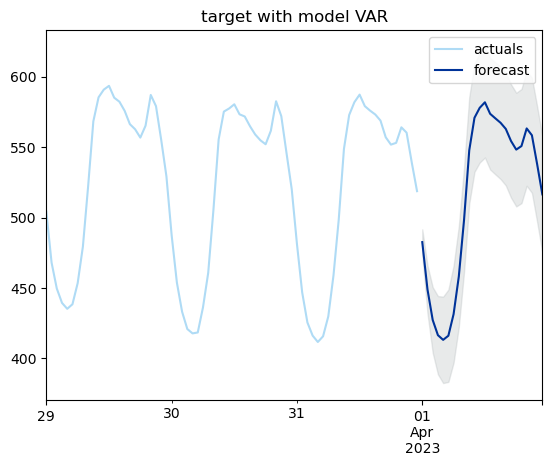

In [41]:
prediction = model.predict()
# plot a sample
prediction.plot(model.df_wide_numeric,
                series=model.df_wide_numeric.columns[0],
                )

In [42]:
print(prediction)

Prediction object: 
Return .forecast, 
 .upper_forecast, 
 .lower_forecast 
 .model_parameters 
 .transformation_parameters


In [43]:
prediction.forecast

,target,temp_last_day
2023-04-01 00:00:00,482.556551,5.736388
2023-04-01 01:00:00,448.968312,5.788188
2023-04-01 02:00:00,427.305928,5.845790
2023-04-01 03:00:00,416.523695,4.735177
2023-04-01 04:00:00,413.212822,4.808946
2023-04-01 05:00:00,416.137239,4.762461
2023-04-01 06:00:00,431.457744,6.189151
2023-04-01 07:00:00,458.123343,6.234212
2023-04-01 08:00:00,498.166951,6.248161
2023-04-01 09:00:00,547.693193,9.185674


In [44]:
# accuracy of all tried model results
model_results = model.results()
# and aggregated from cross validation
validation_results = model.results("validation")

In [45]:
validation_results.sort_values('mae', ascending=True).head(5) #.to_csv('result_val_auto_ts_2.csv')

,ID,Model,ModelParameters,TransformationParameters,Ensemble,Runs,smape,mae,rmse,made,...,uwmse_weighted,smoothness_weighted,containment_weighted,contour_weighted,TotalRuntimeSeconds,Score,lowest_series_mape,lowest_series_mape_name,highest_series_mape,highest_series_mape_name
7,21882579696863510de95cb7849c625d,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},1,1,15.528125,3.306332,4.261304,0.491706,...,3.118282,2.290127,1.0,0.948413,30.4040,9.287913,0.955406,target,22.765050,temp_last_day
4,0d530fd00cc66e6feb1301257420a3c1,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},1,1,17.337772,3.348946,4.299353,0.492401,...,3.282592,2.281806,1.0,0.990079,44.6748,9.192345,0.948665,target,24.112388,temp_last_day
18,743c492eb314159f38cfcd8537b0b67d,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},1,1,17.337772,3.348946,4.299353,0.492401,...,3.282592,2.281806,1.0,0.990079,47.8010,9.192345,0.948665,target,24.112388,temp_last_day
14,56ef1bf92d478a98aeb9ec4c3bb7a83d,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},1,1,17.337772,3.348946,4.299353,0.492401,...,3.282592,2.281806,1.0,0.990079,58.7782,9.192345,0.948665,target,24.112388,temp_last_day
28,e6568724f566881fab25f14213b3a1a7,Ensemble,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{},1,1,7.207822,3.467891,4.449763,0.500140,...,3.456910,2.307183,1.0,0.950397,10.5695,10.819820,1.200133,target,12.924112,temp_last_day


In [46]:
print(model)

Initiated AutoTS object with best model: 
VAR
{'fillna': 'akima', 'transformations': {'0': 'SeasonalDifference'}, 'transformation_params': {'0': {'lag_1': 12, 'method': 'Median'}}}
{'regression_type': None, 'maxlags': None, 'ic': 'fpe'}
Validation: 0
SMAPE: 23.153035163670644
MAE: 3.606499294938172
SPL: 0.6403259555125416


<Axes: title={'center': 'Validation Forecasts for temp_last_day'}, xlabel='datetime'>

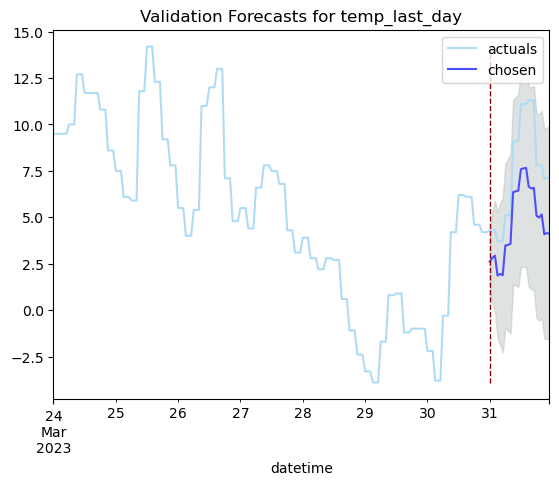

In [47]:
model.plot_validations()

In [49]:
prediction = model.predict(
    future_regressor=regr_fcst, verbose=2, fail_on_forecast_nan=True
)

 
out = prediction.forecast
print(out)


                         target  temp_last_day
2023-04-01 00:00:00  482.556551       5.736388
2023-04-01 01:00:00  448.968312       5.788188
2023-04-01 02:00:00  427.305928       5.845790
2023-04-01 03:00:00  416.523695       4.735177
2023-04-01 04:00:00  413.212822       4.808946
2023-04-01 05:00:00  416.137239       4.762461
2023-04-01 06:00:00  431.457744       6.189151
2023-04-01 07:00:00  458.123343       6.234212
2023-04-01 08:00:00  498.166951       6.248161
2023-04-01 09:00:00  547.693193       9.185674
2023-04-01 10:00:00  570.745015       9.080229
2023-04-01 11:00:00  577.809123       9.014764
2023-04-01 12:00:00  581.740032      10.539811
2023-04-01 13:00:00  573.584290      10.504971
2023-04-01 14:00:00  570.344801      10.464819
2023-04-01 15:00:00  567.194706       9.969631
2023-04-01 16:00:00  562.850652       9.953798
2023-04-01 17:00:00  554.276133      10.069807
2023-04-01 18:00:00  548.179256       7.908601
2023-04-01 19:00:00  550.686357       7.801532
2023-04-01 20

In [50]:
res_df = pd.DataFrame()
#res_df = pd.concat([res_df, out])
df_test_autots['date'] = df_test_autots.index.date
temp_train = df_train_autots
for date, df in df_test_autots.groupby('date'):
    temp_train_df = df.drop(columns='date')
    temp_train = pd.concat([temp_train, temp_train_df])
    
    
    try:
        model = model.fit(
            temp_train
        )
        pred = model.predict(
                future_regressor=regr_fcst, verbose=2, fail_on_forecast_nan=True
                )
        out = pred.forecast
    
        if out['target'].isnull().sum() != 0:
            print('Missing forecast ', date)
        
    except:
        print('Did not execute ', date)
    res_df = pd.concat([res_df, out])
df_test_autots.drop(columns='date')

Data frequency is: H, used frequency is: H
Model Number: 37 with model VAR in generation 0 of 1
Model Number: 38 with model Ensemble in generation 0 of 1
Model Number: 39 with model Ensemble in generation 0 of 1


In [ ]:
print(df_test_autots.shape, res_df.shape)

In [ ]:
mean_absolute_error(df_test_autots['target'], res_df['target'])

In [ ]:
        model = model.fit(
            temp_train,
            
            weights={'target': 20} 
        )
        pred = model.predict()
        out = pred.forecast

In [ ]:
df_test_autots.drop(columns='date')
df_test_autots.head()

In [ ]:
print(model.best_model_name)

In [ ]:
print(model.best_model_params)

In [ ]:

print(model.best_model_transformation_params)

### on new training
model = AutoTS(forecast_length=forecast_length,
               frequency='infer', max_generations=0,
               num_validations=0, verbose=0)
model = model.import_template(example_filename, method='only') # method='add on'
print("Overwrite template is: {}".format(str(model.initial_template)))


In [ ]:
# Рисуем графическое представление предсказания на 2022 год

y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

#pd.DataFrame(date_valid)
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_true_grouped)
tmpdf.plot(x='date', y='target', figsize=(18,5))
ax=plt.gca()
tmpdf = pd.DataFrame(train_ds.loc[features_valid.index,:]['date']).groupby(by='date').count().reset_index().join(y_pred_grouped)
tmpdf.plot(ax=ax, x='date', y=0)

In [ ]:
# Предсказываем той же моделью (19-21) тренировочный кусок 2023 (первый квартал)
mae = mae_day(target_2023, lgbm_model.predict(features_2023))
print(f'mae = {mae}')